In [ ]:
import math
import brian2 as b2
from brian2 import * 
from brian2tools import *
from brian2 import collect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import pandas as pd
import neurodynex3 as nd3
from functions_spectrum import *
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import random
%matplotlib inline
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, spike_tools
from neurodynex3.tools import plot_tools, input_factory
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
import tqdm
import pickle
import logging
logging.getLogger(b2.__name__).setLevel(logging.ERROR)
logging.getLogger(nd3.__name__).setLevel(logging.ERROR)

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
spikes_E = pd.read_csv('spikes_E_EI_before.csv')
spikes_I = pd.read_csv('spikes_I_EI_before.csv')
spikes_E_after = pd.read_csv('spikes_E_EI_after.csv')
spikes_I_after = pd.read_csv('spikes_I_EI_after.csv')
rate_E = pd.read_csv('rate_E_EI_before.csv')
rate_I = pd.read_csv('rate_I_EI_before.csv')
rate_E_after = pd.read_csv('rate_E_EI_after.csv')
rate_I_after = pd.read_csv('rate_I_EI_after.csv')

In [40]:
spikes_E_neur = list(spikes_E.i)
my_dict = {i:spikes_E_neur.count(i)/2.5 for i in range(4000)}
my_dict = dict(sorted(my_dict.items()))

In [41]:
spikes_I_neur = list(spikes_I.i)
my_dict_I = {i:spikes_I_neur.count(i)/2.5 for i in range(1000)}
my_dict_I = dict(sorted(my_dict_I.items()))

In [42]:
spikes_E_neur_after = list(spikes_E_after.i)
my_dict_after = {i:spikes_E_neur_after.count(i)/2.5 for i in range(4000)}
my_dict_after = dict(sorted(my_dict_after.items()))

In [43]:
spikes_I_neur_after = list(spikes_I_after.i)
my_dict_after_I = {i:spikes_I_neur_after.count(i)/2.5 for i in range(1000)}
my_dict_after_I = dict(sorted(my_dict_after_I.items()))

(-5, 55)

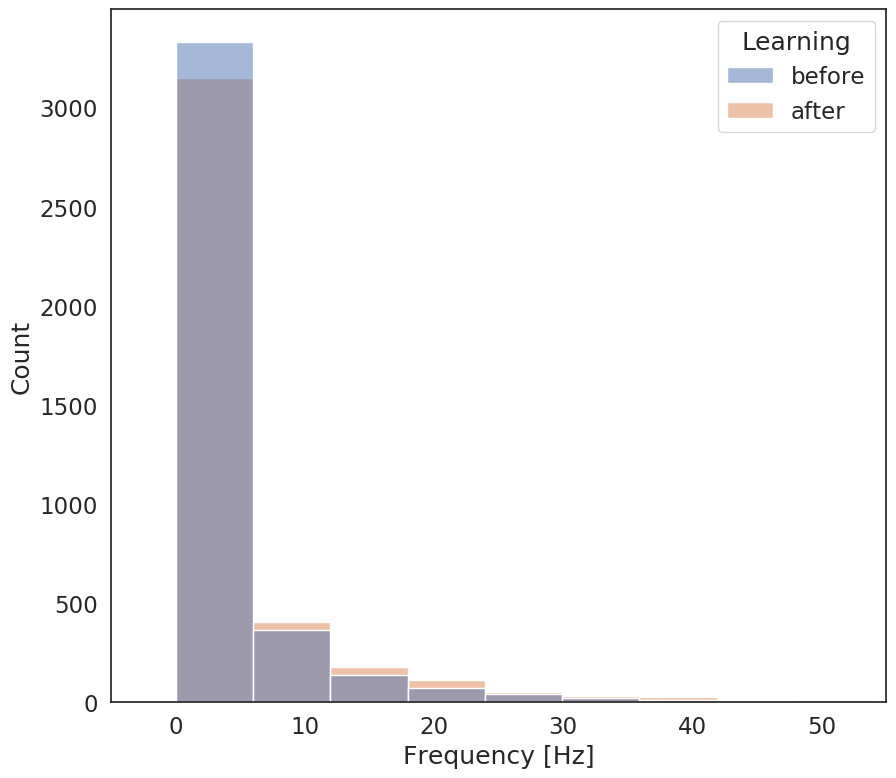

In [ ]:
sns.set(font_scale=1.5, style='white')
stdp = ['before']*len(list(my_dict.values())) + ['after']*len(list(my_dict_after.values()))
df = pd.DataFrame({"Frequency": list(my_dict.values()) + list(my_dict_after.values()), "Neuron indx": list(my_dict.keys()) + list(my_dict_after.keys()), "Learning": stdp})
fig, ax1 = plt.subplots(figsize=(10, 9))
sns.histplot(data=df, x="Frequency", discrete=False, ax=ax1, bins = 20, alpha = 0.5, hue = "Learning")
ax1.set_ylabel("Count", fontsize=18)
ax1.set_xlabel("Frequency [Hz]", fontsize=18)
ax1.set_xlim(-5,55)



(-5, 125)

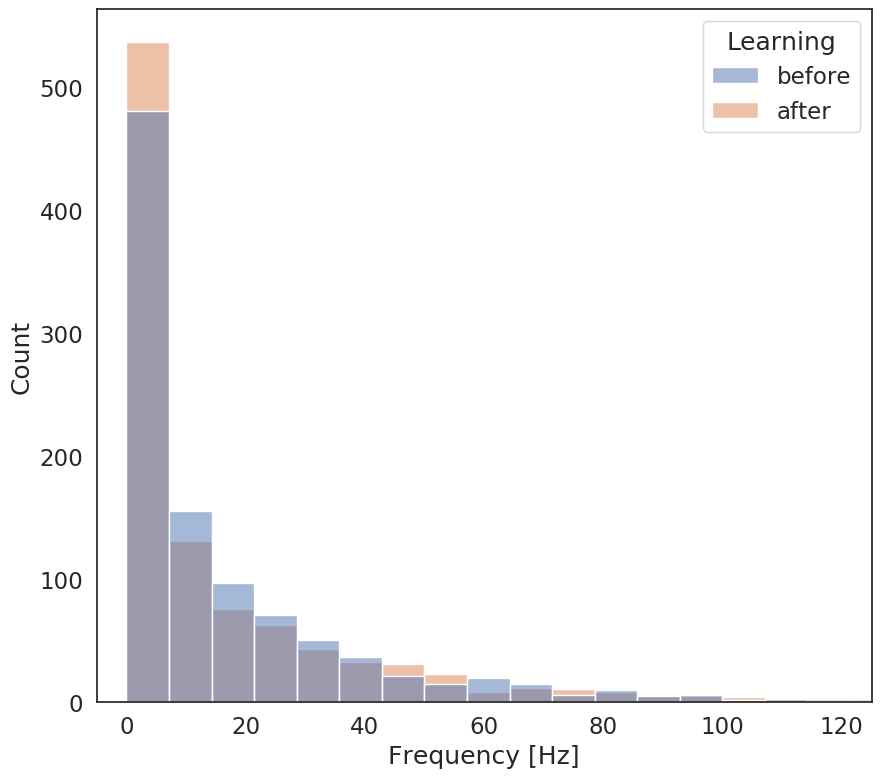

In [ ]:
stdp = ['before']*len(list(my_dict_I.values())) + ['after']*len(list(my_dict_after_I.values()))
df = pd.DataFrame({"Frequency": list(my_dict_I.values()) + list(my_dict_after_I.values()), "Neuron indx": list(my_dict_I.keys()) + list(my_dict_after_I.keys()), "Learning": stdp})
fig, ax1 = plt.subplots(figsize=(10, 9))
sns.histplot(data=df, x="Frequency", discrete=False, ax=ax1, bins = 20, alpha = 0.5, hue = "Learning")
ax1.set_ylabel("Count", fontsize=18)
ax1.set_xlabel("Frequency [Hz]", fontsize=18)
ax1.set_xlim(-5,125)



In [54]:
import pickle


with open('W_evolution_EI_w.pkl', 'rb') as f:
    W_evolution_EI = pickle.load(f)
W_evolution_EI_t = np.loadtxt('W_evolution_EI_t.csv')



In [55]:
weights_before = []
weights_after = []
for i in W_evolution_EI:
    weights_before.append(i[0])
    weights_after.append(i[-1])

Text(0.5, 0, 'Num')

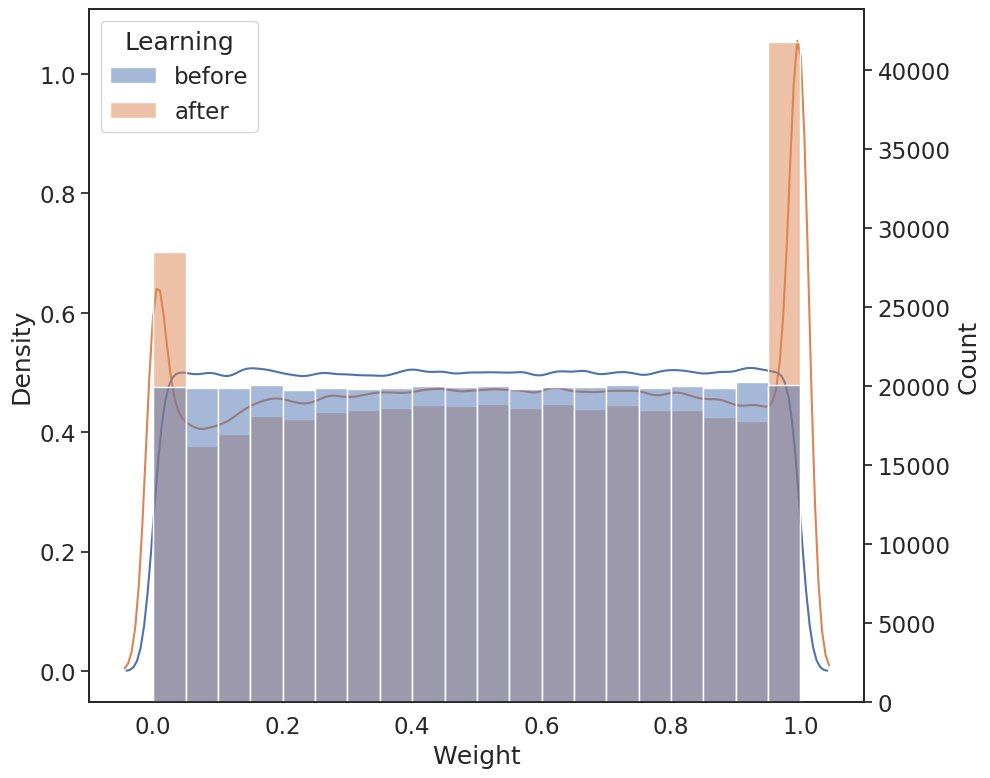

In [ ]:
sns.set(font_scale=1.5, style='white')

nums = weights_before + weights_after
stdp = ['before']*len(weights_before) + ['after']*len(weights_after)
df = pd.DataFrame({"Weight": nums, "Learning": stdp})
fig, ax1 = plt.subplots(figsize=(10, 9))
ax2 = ax1.twinx()
sns.histplot(data=df, x="Weight", discrete=False, ax=ax2, bins = 20, alpha = 0.5, hue = "Learning")
sns.kdeplot(data=df, x="Weight", bw_adjust=.63,ax=ax1,  hue = "Learning", legend = False)
ax1.set_ylabel("Density", fontsize=18)
ax1.set_xlabel("Weight", fontsize=18)
ax2.set_ylabel("Count", fontsize=18)

plt.xlabel("Num")

In [ ]:
# Specify the signal and simulation properties:
delta_t = 0.1 * ms
f_sampling = 1/0.1 * Hz
T_init = 200 * ms
k = 5 #1
N_samples = 5000 #25000
T_signal = 500 *ms #2500
T_sim = k * T_signal + T_init
f_max = 1./(2. * delta_t)
delta_f = 1/(0.1*N_samples) * Hz
N_init = 0

[20. 20.  0. ... 30. 40.  0.]
[ 0. 20. 30. ...  0. 20. 10.]
61


Text(0.5, 1.0, "Power Spectrum of interneurons' population activity for EI plasticity")

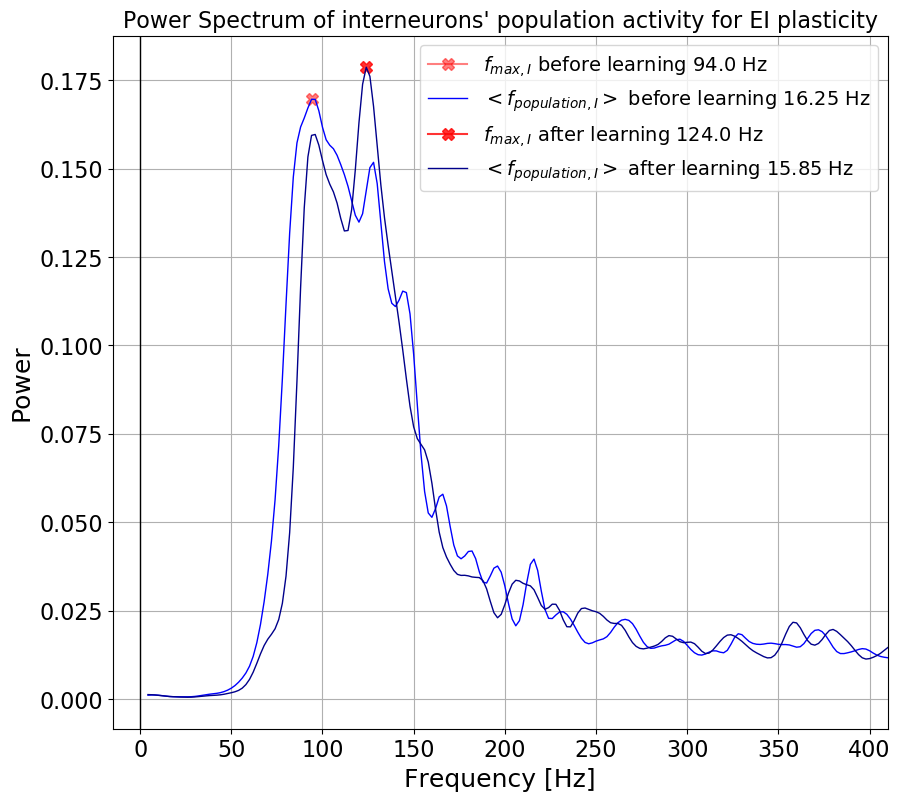

In [ ]:
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_I, delta_f, k, T_init)
pop_freqs_after, pop_ps_after, average_population_rate_after = get_population_activity_power_spectrum(rate_I_after, delta_f, k, T_init)
print(list(pop_ps_after[1:]).index(max(pop_ps_after[1:])))
max_freq = 300 *Hz
x_sm = np.array(pop_freqs[1:])
y_sm = np.array(pop_ps[1:])
x_smooth = np.linspace(x_sm.min(), x_sm.max(), 5000)
sigma = 2
x_g1d_2 = gaussian_filter1d(pop_freqs[1:], sigma)
y_g1d_2 = gaussian_filter1d(pop_ps[1:], sigma)
x_g1d_after = gaussian_filter1d(pop_freqs_after[1:], sigma)
y_g1d_after = gaussian_filter1d(pop_ps_after[1:], sigma)
fig = figure(figsize=(10, 9))
plt.plot(x_g1d_2[list(y_g1d_2).index(max(y_g1d_2))], max(y_g1d_2), marker = "X", markersize = 8, color = "red", alpha = 0.5, label = '$f_{max, I}$ before learning %s Hz'  % np.round(x_g1d_2[list(y_g1d_2).index(max(y_g1d_2))],2))
plt.plot(x_g1d_2, y_g1d_2, 'b', linewidth=1, label = '$<f_{population, I}>$ before learning %s Hz'  % np.round(np.mean(rate_I.rate),2))
plt.plot(x_g1d_after[list(y_g1d_after).index(max(y_g1d_after))], max(y_g1d_after), marker = "X", markersize = 8, color = "red", alpha = 0.8, label = '$f_{max, I}$ after learning %s Hz'  % np.round(x_g1d_after[list(y_g1d_after).index(max(y_g1d_after))],2))
plt.plot(x_g1d_after, y_g1d_after, "darkblue", linewidth=1, label = '$<f_{population, I}>$ after learning %s Hz'  % np.round(np.mean(rate_I_after.rate),2))
plt.axvline(x=0., lw=1, color="k")
plt.xlim([-.05*max_freq/b2.Hz,410])
plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("Frequency [Hz]",fontsize = 18)
plt.ylabel("Power",fontsize = 18)
plt.title("Power Spectrum of interneurons' population activity for EI plasticity", fontsize = 16)

[0.  2.5 2.5 ... 7.5 0.  5. ]
[12.5  5.   2.5 ...  2.5  7.5  0. ]
44


Text(0.5, 1.0, "Power Spectrum of pyramidals' population activity for EI plasticity")

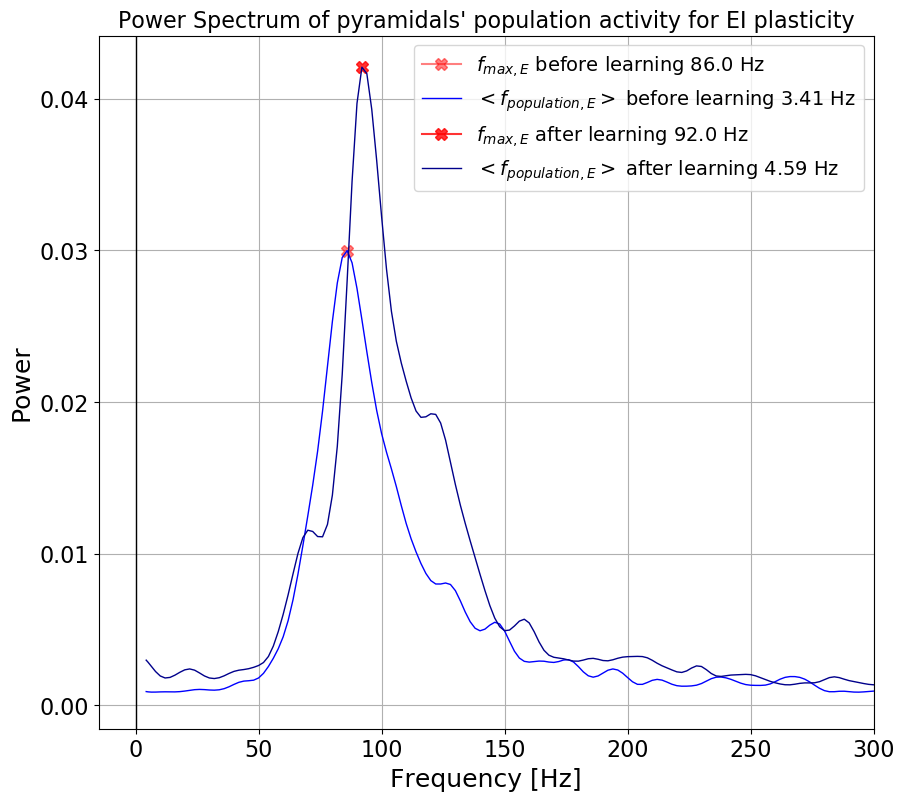

In [ ]:
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E, delta_f, k, T_init)
pop_freqs_after, pop_ps_after, average_population_rate_after = get_population_activity_power_spectrum(rate_E_after, delta_f, k, T_init)
print(list(pop_ps_after[1:]).index(max(pop_ps_after[1:])))
max_freq = 300 *Hz
x_sm = np.array(pop_freqs[1:])
y_sm = np.array(pop_ps[1:])
x_smooth = np.linspace(x_sm.min(), x_sm.max(), 5000)
sigma = 2
x_g1d_2 = gaussian_filter1d(pop_freqs[1:], sigma)
y_g1d_2 = gaussian_filter1d(pop_ps[1:], sigma)
x_g1d_after = gaussian_filter1d(pop_freqs_after[1:], sigma)
y_g1d_after = gaussian_filter1d(pop_ps_after[1:], sigma)
fig = figure(figsize=(10, 9))
plt.plot(x_g1d_2[list(y_g1d_2).index(max(y_g1d_2))], max(y_g1d_2), marker = "X", markersize = 8, color = "red", alpha = 0.5, label = '$f_{max, E}$ before learning %s Hz'  % np.round(x_g1d_2[list(y_g1d_2).index(max(y_g1d_2))],2))
plt.plot(x_g1d_2, y_g1d_2, 'b', linewidth=1, label = '$<f_{population, E}>$ before learning %s Hz'  % np.round(np.mean(rate_E.rate),2))
plt.plot(x_g1d_after[list(y_g1d_after).index(max(y_g1d_after))], max(y_g1d_after), marker = "X", markersize = 8, color = "red", alpha = 0.8, label = '$f_{max, E}$ after learning %s Hz'  % np.round(x_g1d_after[list(y_g1d_after).index(max(y_g1d_after))],2))
plt.plot(x_g1d_after, y_g1d_after, "darkblue", linewidth=1, label = '$<f_{population, E}>$ after learning %s Hz'  % np.round(np.mean(rate_E_after.rate),2))
plt.axvline(x=0., lw=1, color="k")
plt.xlim([-.05*max_freq/b2.Hz, max_freq/b2.Hz])
plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("Frequency [Hz]",fontsize = 18)
plt.ylabel("Power",fontsize = 18)
plt.title("Power Spectrum of pyramidals' population activity for EI plasticity", fontsize = 16)

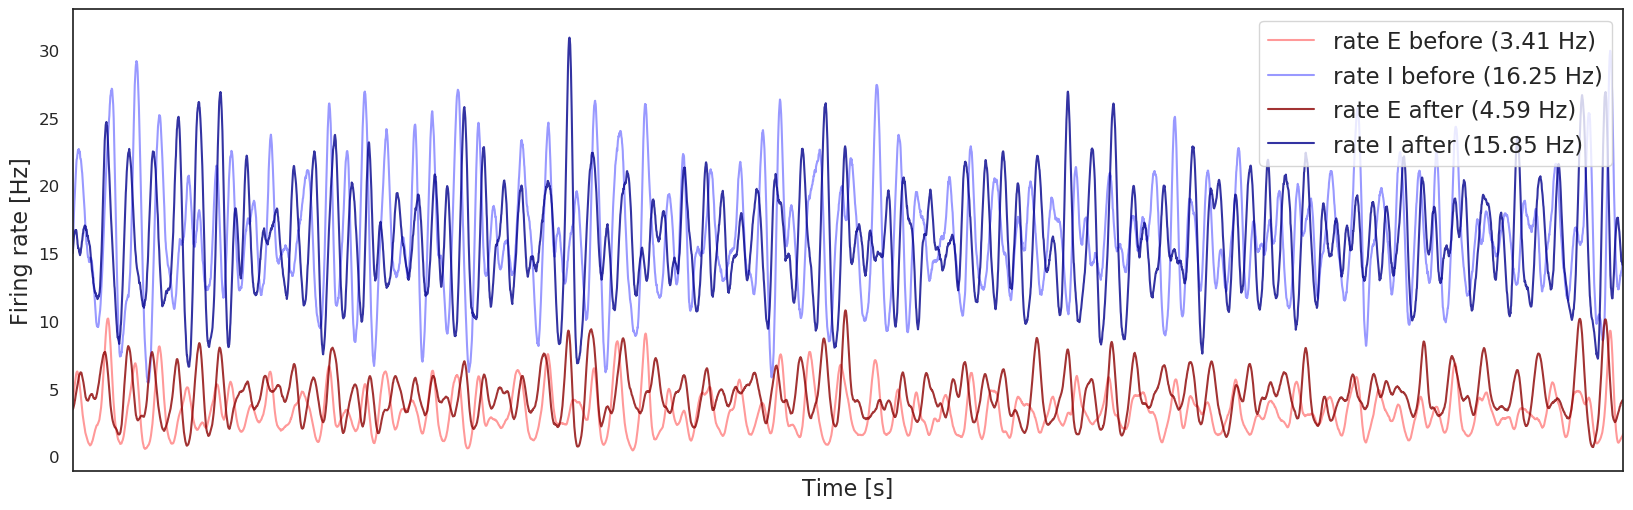

In [ ]:
fig = figure(figsize=(20, 6))
smooth_width = 1*ms
plt.plot(rate_E.t, smooth_rate(rate_E, window='gaussian', width=1 *msecond), color = 'red', alpha = 0.4, label = 'rate E before (%s Hz)'  % np.round(np.mean(rate_E.rate),2))
plt.plot(rate_I.t, smooth_rate(rate_I, window='gaussian', width=1 *msecond), color = 'blue', alpha = 0.4, label = 'rate I before (%s Hz)'  % np.round(np.mean(rate_I.rate),2))
plt.plot(rate_E.t, smooth_rate(rate_E_after, window='gaussian', width=1 *msecond), color = 'darkred', alpha = 0.8, label = 'rate E after (%s Hz)'  % np.round(np.mean(rate_E_after.rate),2))
plt.plot(rate_I.t, smooth_rate(rate_I_after, window='gaussian', width=1 *msecond), color = 'darkblue', alpha = 0.8, label = 'rate I after (%s Hz)'  % np.round(np.mean(rate_I_after.rate),2))
plt.legend()
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.show()

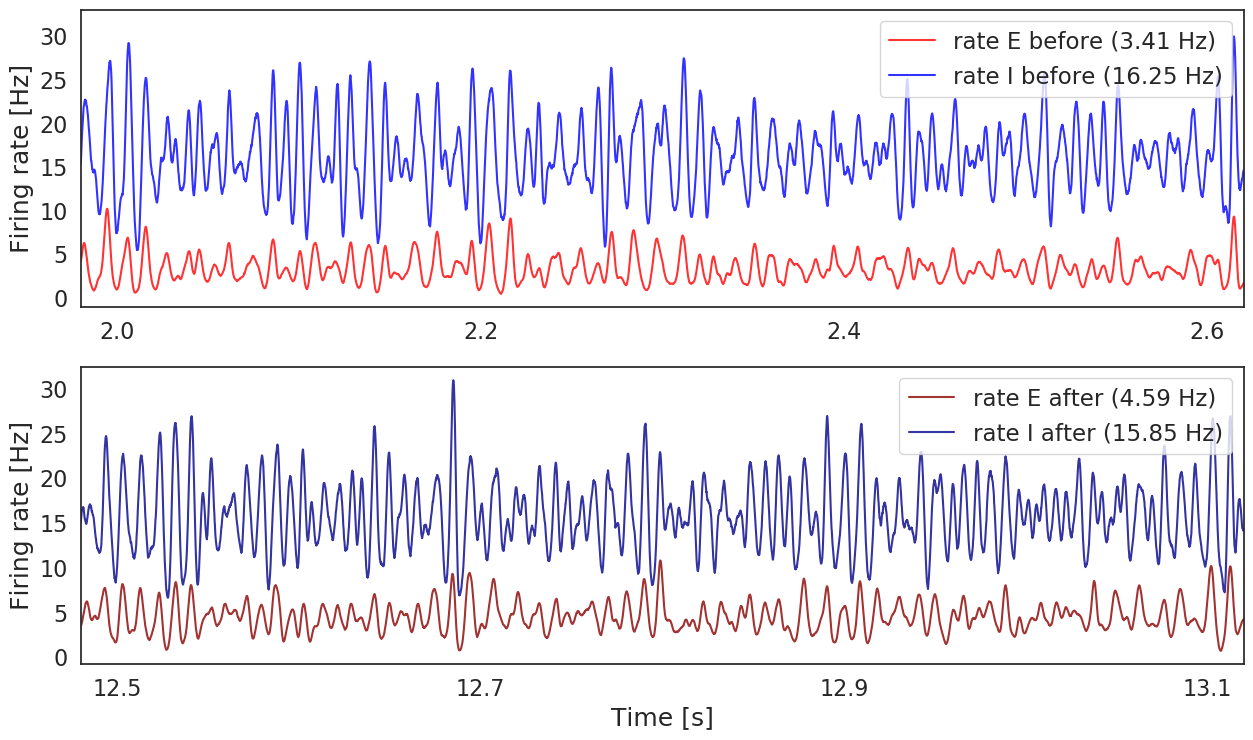

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8.5))
ax1.plot(rate_E.t, smooth_rate(rate_E, window='gaussian', width=1 *msecond), color = 'red', alpha = 0.8, label = 'rate E before (%s Hz)'  % np.round(np.mean(rate_E.rate),2))
ax1.plot(rate_I.t, smooth_rate(rate_I, window='gaussian', width=1 *msecond), color = 'blue', alpha = 0.8, label = 'rate I before (%s Hz)'  % np.round(np.mean(rate_I.rate),2))
ax1.legend(loc = 'upper right')
ax1.set_ylabel('Firing rate [Hz]', size = 18)
ax1.set_xlim(1.98, 2.62)
ax1.set_xticks([2.0, 2.2, 2.4, 2.6])
ax1.set_yticks([0, 5, 10, 15, 20, 25, 30])
ax1.tick_params(labelsize=16)
ax2.plot(rate_E_after.t, smooth_rate(rate_E_after, window='gaussian', width=1 *msecond), color = 'darkred', alpha = 0.8, label = 'rate E after (%s Hz)'  % np.round(np.mean(rate_E_after.rate),2))
ax2.plot(rate_I_after.t, smooth_rate(rate_I_after, window='gaussian', width=1 *msecond), color = 'darkblue', alpha = 0.8, label = 'rate I after (%s Hz)'  % np.round(np.mean(rate_I_after.rate),2))
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Time [s]', size = 18)
ax2.set_ylabel('Firing rate [Hz]', size = 18)
ax2.set_xlim(12.48, 13.12)
ax2.set_xticks([12.5, 12.7, 12.9, 13.1])
ax2.set_yticks([0, 5, 10, 15, 20, 25, 30])
ax2.tick_params(labelsize=16)
plt.show()

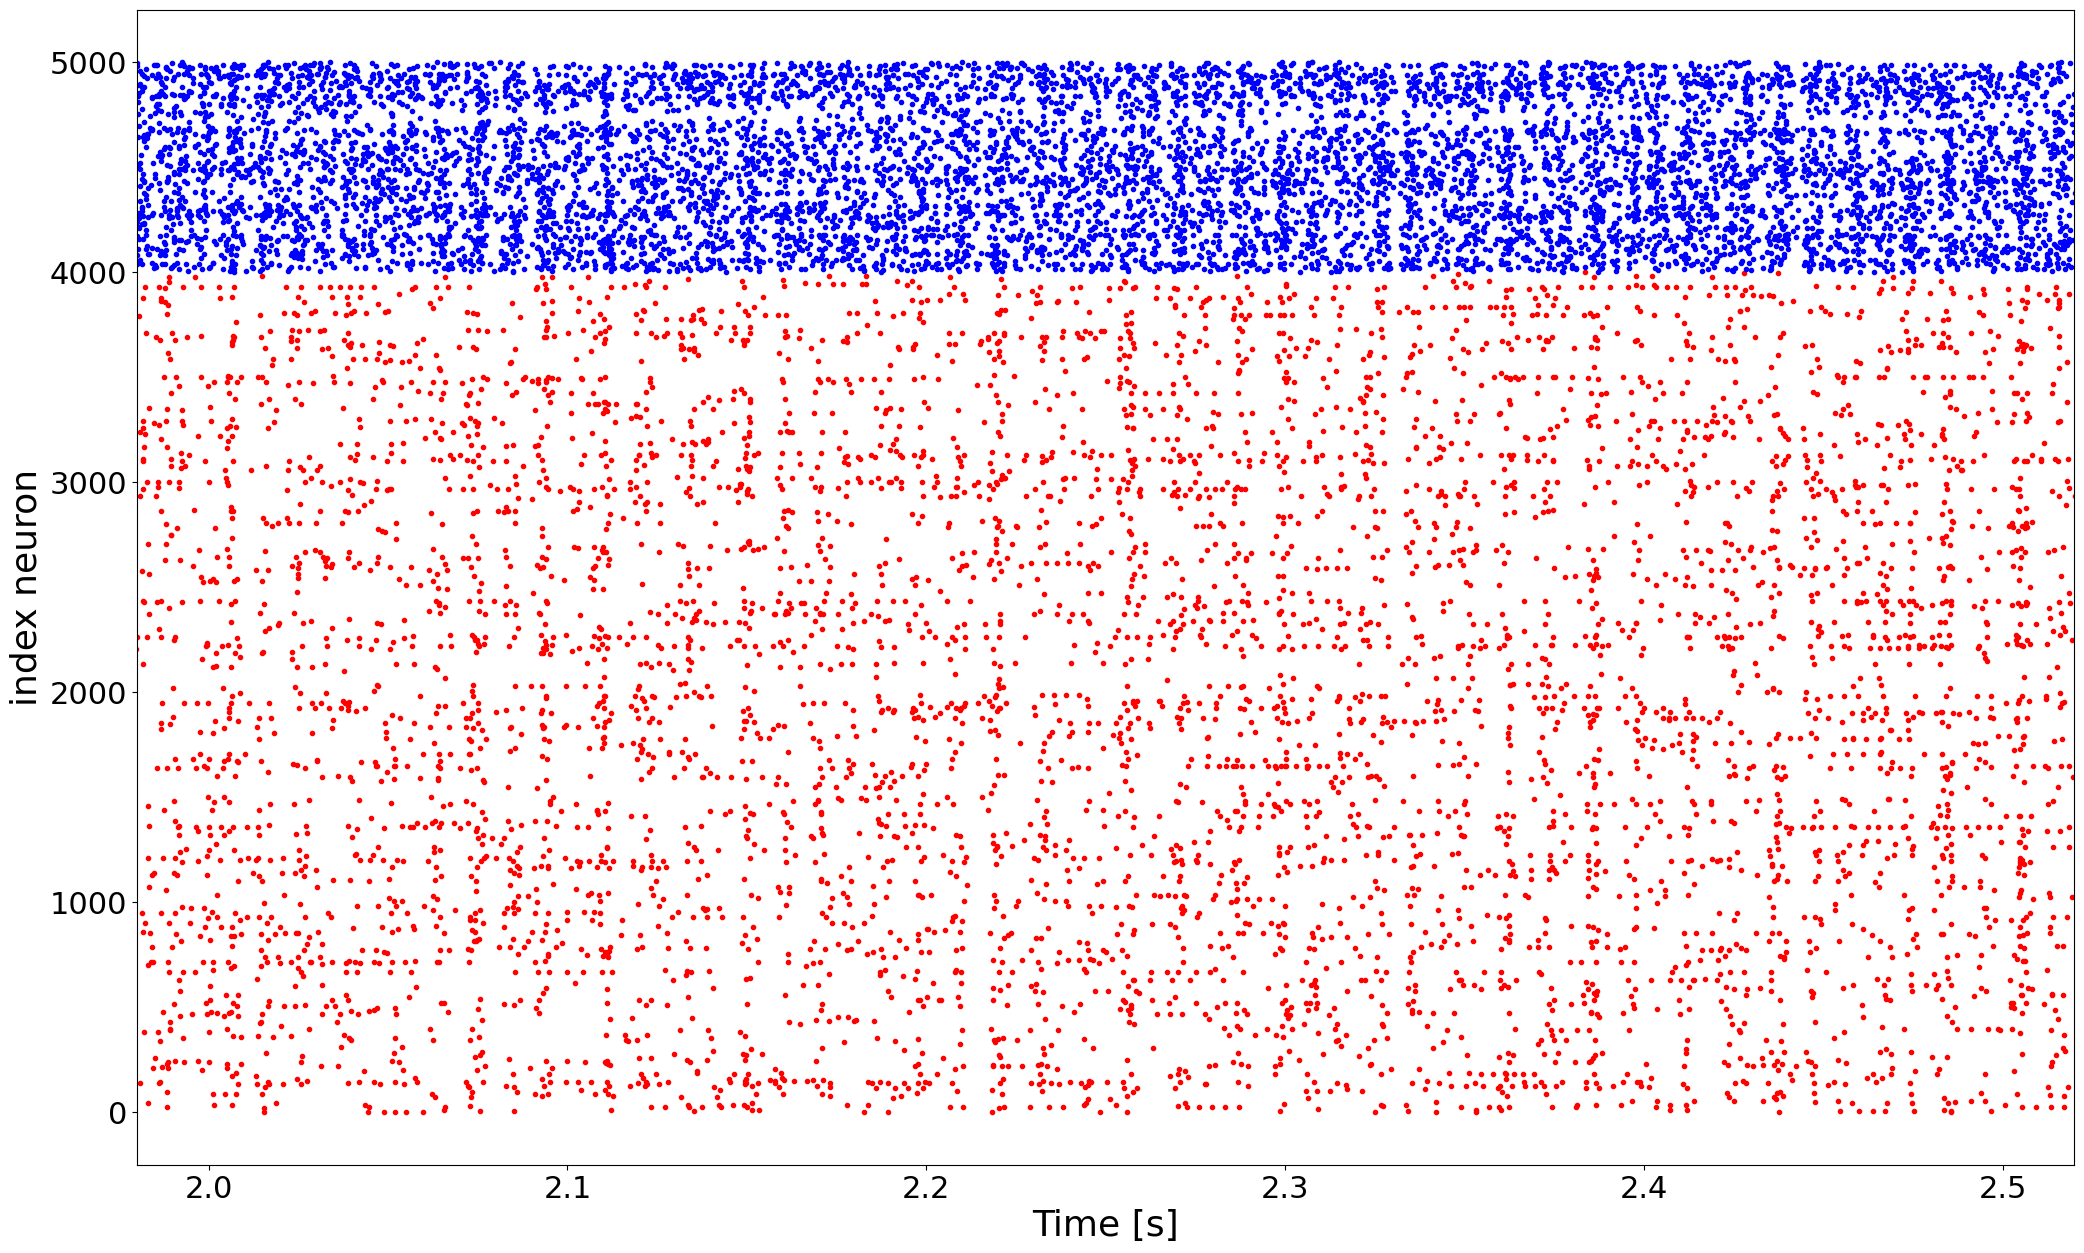

In [ ]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E.t, spikes_E.i, '.', color = 'r')
plt.plot(spikes_I.t, spikes_I.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(1.98, 2.52)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

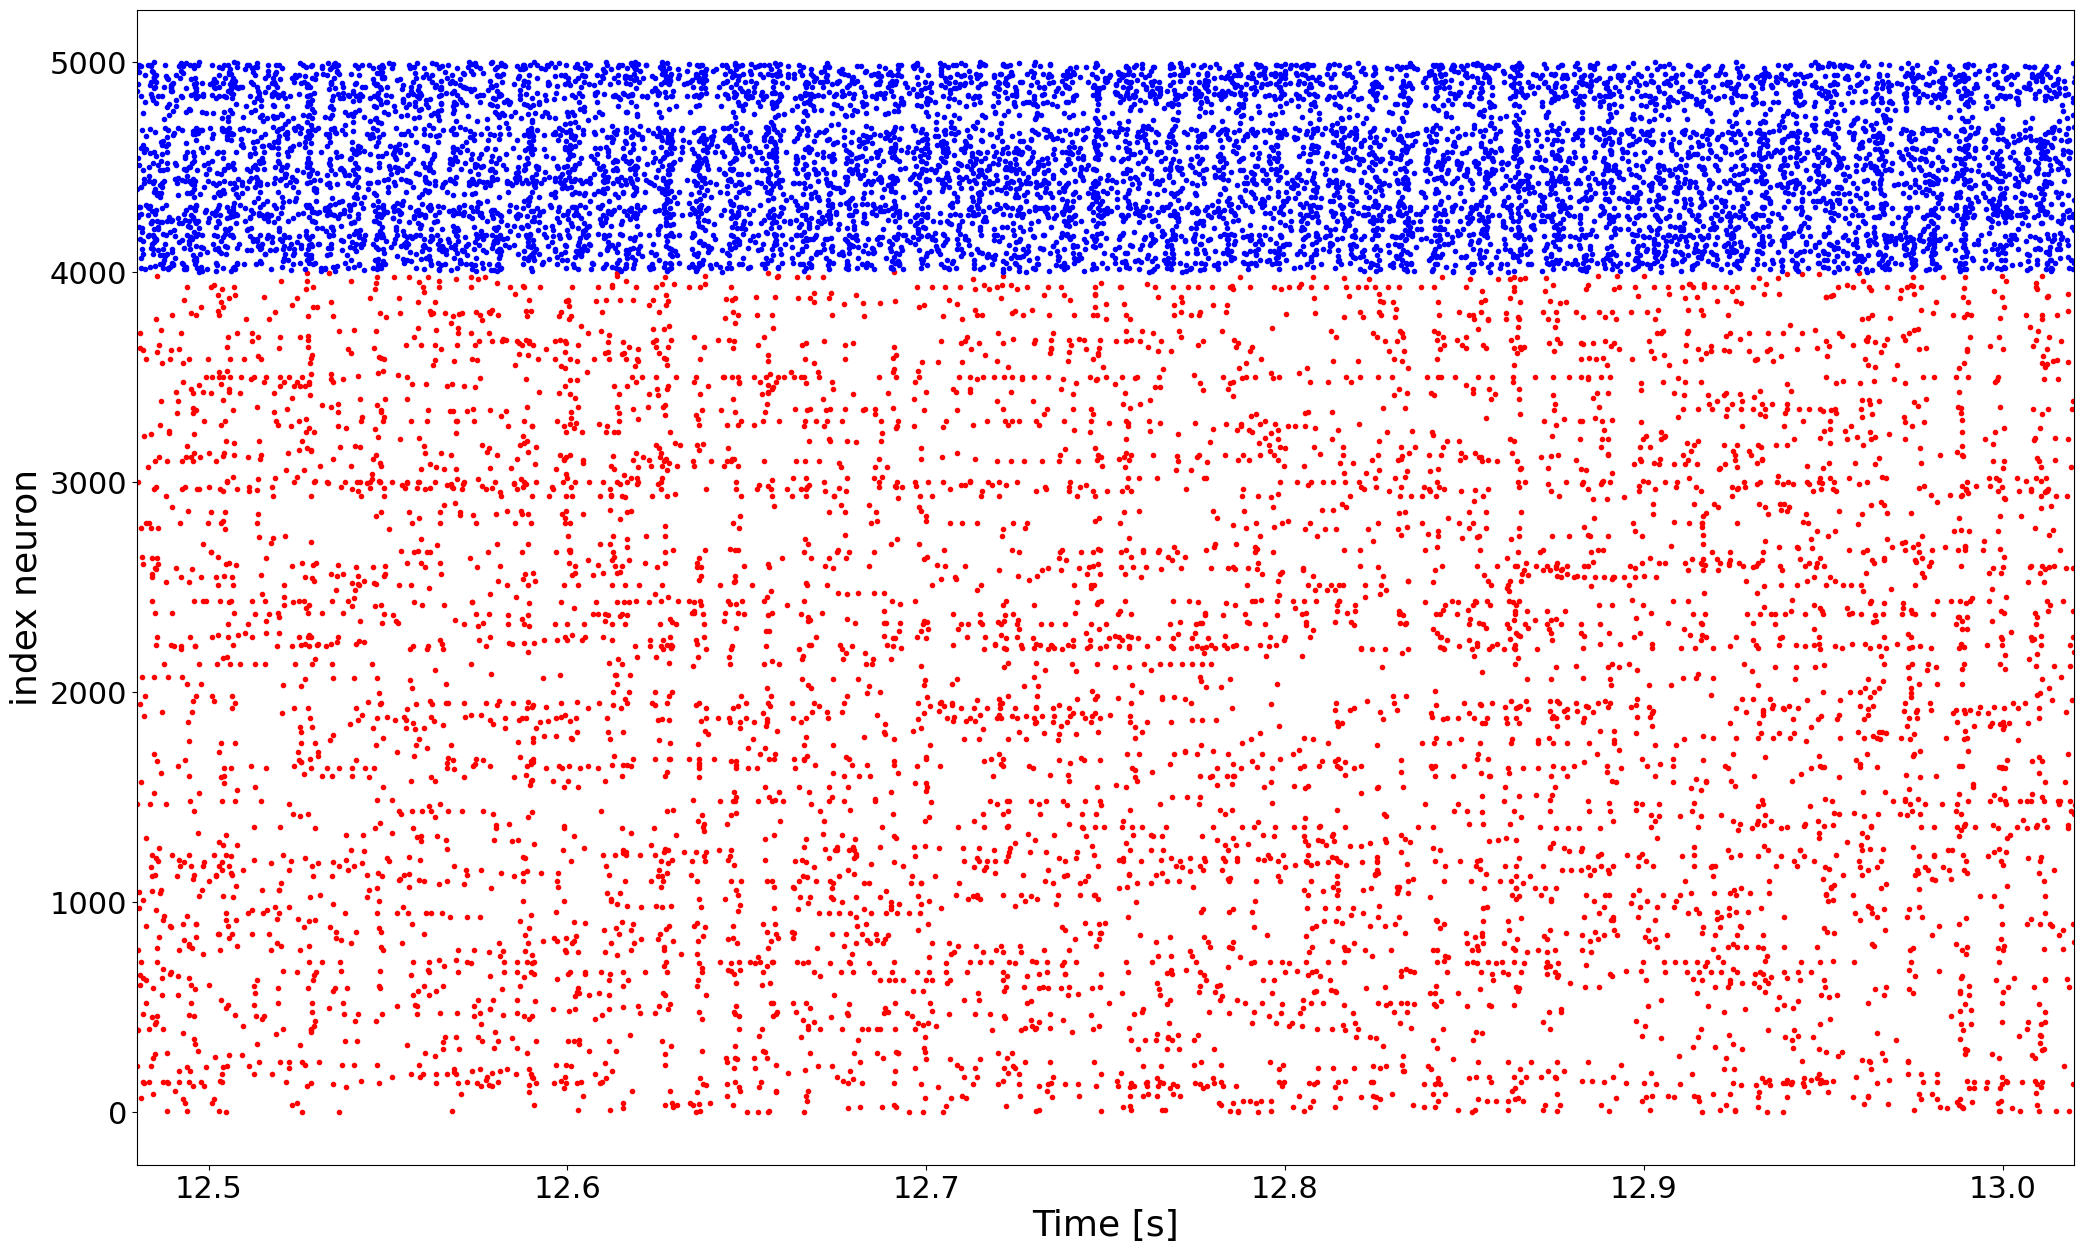

In [ ]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E.t, spikes_E.i, '.', color = 'r')
plt.plot(spikes_I.t, spikes_I.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(1.98, 2.52)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()